In [3]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# Define dataset paths
DATA_DIR = "datasets_img"  # Main directory for organized data
LSBGs_DIR = "original\\1_LSBGs"  # Positive class folder
NEG_DIR = "original\\0_neg_typ_2"  # Negative class folder
MODEL_DIR = "models"

In [4]:

def plot_sample_images(folder_path, title, num_samples=5):
    """
    Plots a specified number of sample images from a given folder.
    
    Args:
        folder_path (str): Path to the folder containing images.
        num_samples (int): Number of images to randomly sample and display.
    """
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return

    # Randomly select `num_samples` images (or all if fewer exist)
    selected_files = random.sample(image_files, min(len(image_files), num_samples))

    # Plot images
    fig, axes = plt.subplots(1, len(selected_files), figsize=(12, 3))
    fig.suptitle(title, fontsize=16)

    if len(selected_files) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only 1 image

    for ax, img_name in zip(axes, selected_files):
        img_path = os.path.join(folder_path, img_name)
        image = Image.open(img_path)

        # Convert grayscale images to RGB (for consistency)
        image = image.convert("RGB")

        ax.imshow(image)
        ax.axis("off")
        ax.set_title(img_name[:10] + "...")  # Show truncated filename

    plt.tight_layout()
    plt.show()


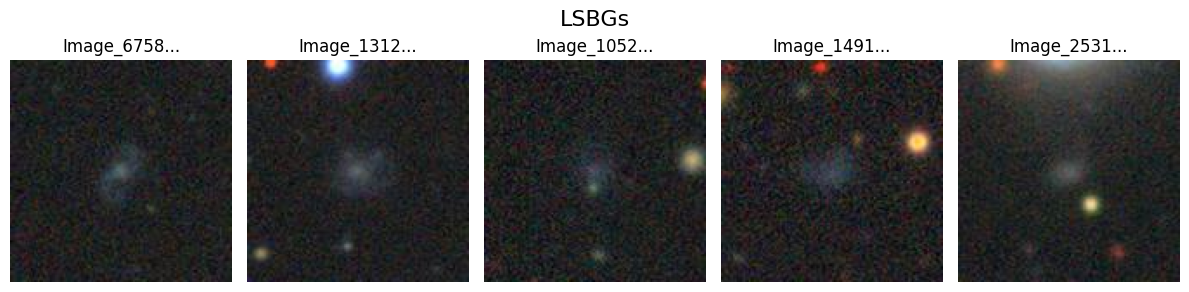

In [5]:
plot_sample_images(os.path.join(DATA_DIR, LSBGs_DIR), 'LSBGs', 5)

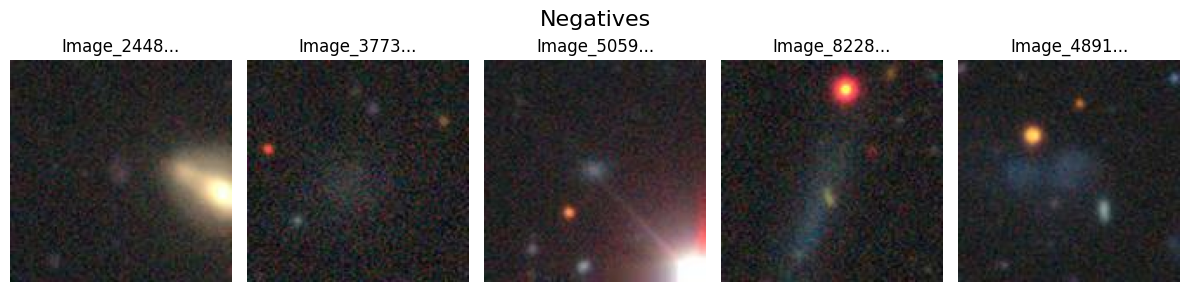

In [6]:
plot_sample_images(os.path.join(DATA_DIR, NEG_DIR), 'Negatives', 5)

In [ ]:
import os
import shutil
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define splits (Train: 80%, Val: 10%, Test: 10%)
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# Create organized dataset structure if not exists
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATA_DIR, split, "1_LSBGs"), exist_ok=True)
    os.makedirs(os.path.join(DATA_DIR, split, "0_neg_typ_2"), exist_ok=True)

def split_and_copy_images(class_dir, class_name):
    """
    Splits images into train, val, and test folders while preserving binary classification labels.
    """
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_files)  # Shuffle before splitting

    # Split sizes
    train_size = int(len(image_files) * TRAIN_RATIO)
    val_size = int(len(image_files) * VAL_RATIO)
    test_size = len(image_files) - train_size - val_size  # Remaining for test

    # Assign images to each set
    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]

    # Copy files to new dataset structure
    for file, split in zip([train_files, val_files, test_files], ["train", "val", "test"]):
        for img in file:
            src = os.path.join(class_dir, img)
            dst = os.path.join(DATA_DIR, split, class_name, img)
            shutil.copy(src, dst)

    print(f"Processed {class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

# Split and copy images
split_and_copy_images(os.path.join(DATA_DIR, LSBGs_DIR), "1_LSBGs")
split_and_copy_images(os.path.join(DATA_DIR, NEG_DIR), "0_neg_typ_2")

# Define transformations (resizing, normalization for pre-trained models)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize for ResNet, EfficientNet, etc.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "val"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")

# Print class mapping (should be {'LSBGs': 0, 'neg_typ_2': 1})
print("Class Mapping:", train_dataset.class_to_idx)


Processed 1_LSBGs: Train=7428, Val=928, Test=930
Processed 0_neg_typ_2: Train=6952, Val=869, Test=870
Train: 14380 images
Val: 1797 images
Test: 1800 images
Class Mapping: {'0_neg_typ_2': 0, '1_LSBGs': 1}


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# 🔹 Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Function to evaluate model and plot confusion matrix
def evaluate_model(model, dataloader):
    y_true = []
    y_pred = []

    # Disable gradients for inference
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Store true labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ["0_neg_typ_2", "1_LSBGs"]

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print(f"{cm}\n")

    # Print classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# 🔹 Function to Load Pretrained Model and Modify it for Classification
def get_model(model_name, fine_tune_layers=10):
    """
    Loads a pretrained model and modifies it for fine-tuned binary classification.
    
    Args:
        model_name (str): Model architecture name.
        fine_tune_layers (int): How many of the last layers to unfreeze.

    Returns:
        model (torch.nn.Module): Modified fine-tuned model.
    """
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    elif model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    elif model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    elif model_name == "vgg19":
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # 🔹 Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # 🔹 Modify Fully Connected (FC) Layer for Binary Classification
    if "resnet" in model_name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)

        # ✅ Unfreeze only the last `fine_tune_layers` layers
        for param in list(model.layer4.parameters())[-fine_tune_layers:]:
            param.requires_grad = True  

    elif "vgg" in model_name:
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, 2)

        # ✅ Unfreeze the last `fine_tune_layers` layers in VGG
        for param in list(model.features.parameters())[-fine_tune_layers:]:
            param.requires_grad = True  

    elif "efficientnet" in model_name:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 2)

        # ✅ Unfreeze the last `fine_tune_layers` blocks
        for param in list(model.features.parameters())[-fine_tune_layers:]:
            param.requires_grad = True  

    return model.to(device)




# 🔹 Training and Validation Logic
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, model_name):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.model_name = model_name
        self.best_val_loss = float("inf")
        
        # ✅ Fixed List Initialization
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_model(self, num_epochs, save_dir):
        """
        Trains the model and evaluates it.
        
        Args:
            num_epochs (int): Number of training epochs.
            save_dir (str): Directory to save the best model.
        """
        #os.makedirs(save_dir, exist_ok=True)

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Training Phase
            self.model.train()
            running_loss, correct, total = 0.0, 0, 0

            # ✅ tqdm Progress Bar for Training
            train_progress = tqdm(self.train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
            for images, labels in train_progress:
                images, labels = images.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # ✅ Update tqdm bar with current loss
                train_progress.set_postfix(loss=loss.item(), acc=100 * correct / total)

            train_loss = running_loss / len(self.train_loader)
            train_acc = 100 * correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

            # Validation Phase
            self.model.eval()
            val_loss, correct, total = 0.0, 0, 0

            # ✅ tqdm Progress Bar for Validation
            val_progress = tqdm(self.val_loader, desc=f"Validating Epoch {epoch+1}", leave=False)
            with torch.no_grad():
                for images, labels in val_progress:
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    # ✅ Update tqdm bar with current loss
                    val_progress.set_postfix(loss=loss.item(), acc=100 * correct / total)

            val_loss = val_loss / len(self.val_loader)
            val_acc = 100 * correct / total
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

            # Save Best Model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), save_dir)
                print(f"✅ Best model saved: {save_dir}")

        # Plot training curves
        self.plot_training_curves()

    def plot_training_curves(self):
        """
        Plots loss and accuracy curves.
        """
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Train Loss")
        plt.plot(epochs, self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.model_name}: Training & Validation Loss")
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label="Train Accuracy")
        plt.plot(epochs, self.val_accuracies, label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"{self.model_name}: Training & Validation Accuracy")
        plt.legend()
        plt.show()



Using device: cuda


Training vgg16

Epoch 1/10


Train Loss: 0.4570, Train Accuracy: 78.45%


Val Loss: 0.3392, Val Accuracy: 85.98%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 2/10


Train Loss: 0.2967, Train Accuracy: 88.07%


Val Loss: 0.2869, Val Accuracy: 87.81%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 3/10


Train Loss: 0.2615, Train Accuracy: 89.80%


Val Loss: 0.2799, Val Accuracy: 87.53%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 4/10


Train Loss: 0.2366, Train Accuracy: 90.76%


Val Loss: 0.2630, Val Accuracy: 88.31%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 5/10


Train Loss: 0.2166, Train Accuracy: 91.51%


Val Loss: 0.2604, Val Accuracy: 88.76%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 6/10


Train Loss: 0.1989, Train Accuracy: 92.45%


Val Loss: 0.2570, Val Accuracy: 88.81%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 7/10


Train Loss: 0.1806, Train Accuracy: 93.11%


Val Loss: 0.2627, Val Accuracy: 88.81%

Epoch 8/10


Train Loss: 0.1611, Train Accuracy: 94.10%


Val Loss: 0.2707, Val Accuracy: 88.54%

Epoch 9/10


Train Loss: 0.1399, Train Accuracy: 95.20%


Val Loss: 0.2646, Val Accuracy: 88.87%

Epoch 10/10


Train Loss: 0.1165, Train Accuracy: 95.96%


Val Loss: 0.3004, Val Accuracy: 88.48%


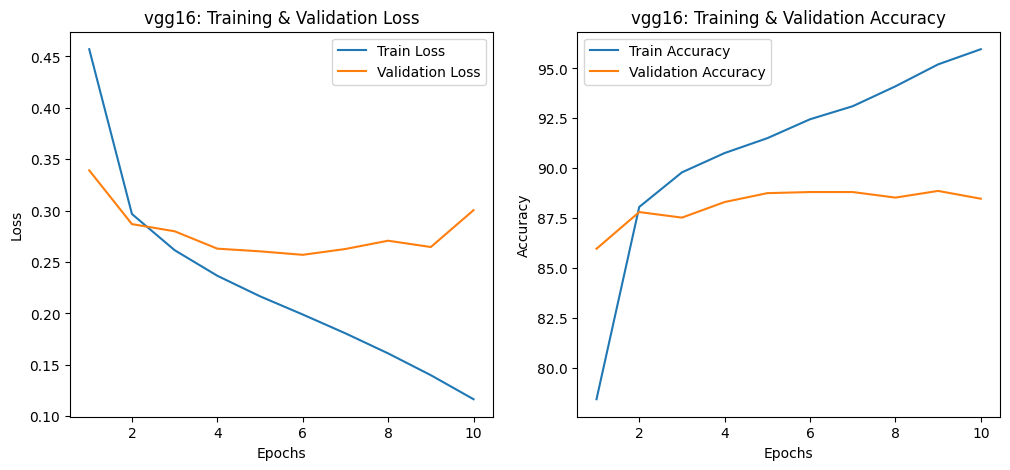

Training resnet50

Epoch 1/10


Train Loss: 0.6517, Train Accuracy: 64.59%


Val Loss: 0.5985, Val Accuracy: 72.29%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 2/10


Train Loss: 0.5469, Train Accuracy: 76.23%


Val Loss: 0.5096, Val Accuracy: 76.52%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 3/10


Train Loss: 0.4613, Train Accuracy: 80.25%


Val Loss: 0.4631, Val Accuracy: 78.69%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 4/10


Train Loss: 0.4207, Train Accuracy: 81.80%


Val Loss: 0.4419, Val Accuracy: 79.86%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 5/10


Train Loss: 0.3949, Train Accuracy: 82.72%


Val Loss: 0.4278, Val Accuracy: 80.97%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 6/10


Train Loss: 0.3700, Train Accuracy: 83.94%


Val Loss: 0.4220, Val Accuracy: 81.19%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 7/10


Train Loss: 0.3554, Train Accuracy: 84.74%


Val Loss: 0.4121, Val Accuracy: 82.97%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 8/10


Train Loss: 0.3379, Train Accuracy: 85.39%


Val Loss: 0.4088, Val Accuracy: 82.69%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 9/10


Train Loss: 0.3306, Train Accuracy: 85.56%


Val Loss: 0.4035, Val Accuracy: 83.53%
✅ Best model saved: models\resnet50_fine_tune.pth

Epoch 10/10


Train Loss: 0.3109, Train Accuracy: 86.49%


Val Loss: 0.3970, Val Accuracy: 84.42%
✅ Best model saved: models\resnet50_fine_tune.pth


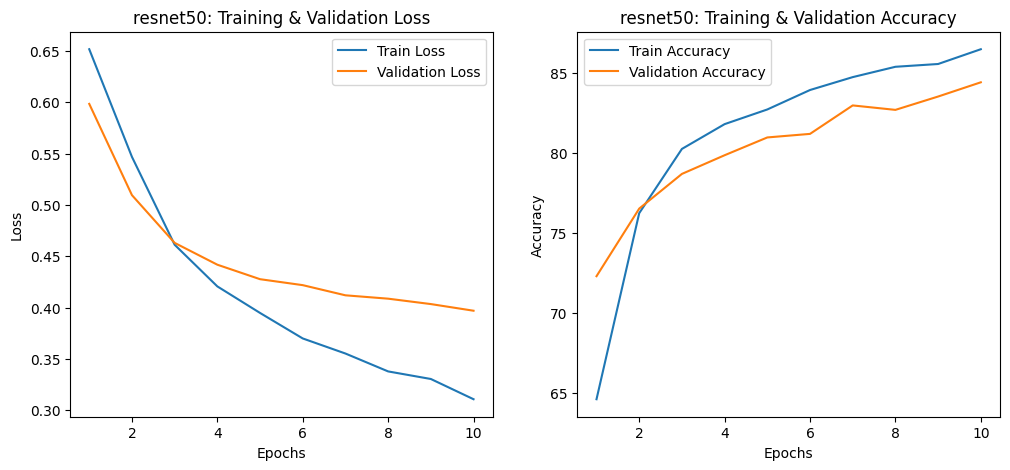

Training resnet18

Epoch 1/10


Train Loss: 0.5366, Train Accuracy: 72.91%


Val Loss: 0.4659, Val Accuracy: 79.47%
✅ Best model saved: models\resnet18_fine_tune.pth

Epoch 2/10


Train Loss: 0.4192, Train Accuracy: 81.85%


Val Loss: 0.4298, Val Accuracy: 81.25%
✅ Best model saved: models\resnet18_fine_tune.pth

Epoch 3/10


Train Loss: 0.3754, Train Accuracy: 84.17%


Val Loss: 0.4124, Val Accuracy: 81.80%
✅ Best model saved: models\resnet18_fine_tune.pth

Epoch 4/10


Train Loss: 0.3431, Train Accuracy: 85.73%


Val Loss: 0.4008, Val Accuracy: 82.69%
✅ Best model saved: models\resnet18_fine_tune.pth

Epoch 5/10


Train Loss: 0.3158, Train Accuracy: 86.95%


Val Loss: 0.3939, Val Accuracy: 82.69%
✅ Best model saved: models\resnet18_fine_tune.pth

Epoch 6/10


Train Loss: 0.2933, Train Accuracy: 88.14%


Val Loss: 0.3880, Val Accuracy: 82.75%
✅ Best model saved: models\resnet18_fine_tune.pth

Epoch 7/10


Train Loss: 0.2721, Train Accuracy: 88.80%


Val Loss: 0.3883, Val Accuracy: 83.64%

Epoch 8/10


Train Loss: 0.2529, Train Accuracy: 90.15%


Val Loss: 0.3866, Val Accuracy: 83.97%
✅ Best model saved: models\resnet18_fine_tune.pth

Epoch 9/10


Train Loss: 0.2334, Train Accuracy: 91.33%


Val Loss: 0.3880, Val Accuracy: 84.03%

Epoch 10/10


Train Loss: 0.2119, Train Accuracy: 92.16%


Val Loss: 0.3882, Val Accuracy: 83.86%


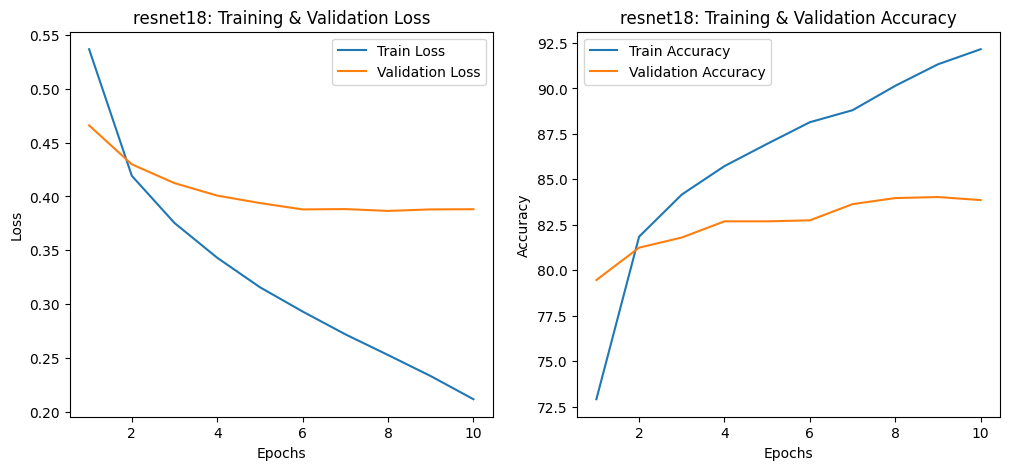

Training efficientnet_b0


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001E8778DA840>
Traceback (most recent call last):
  File "c:\MNA\DeepShadows\venv_deepShadows\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "c:\MNA\DeepShadows\venv_deepShadows\Lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'



Epoch 1/10


Train Loss: 0.6612, Train Accuracy: 60.33%


Val Loss: 0.6543, Val Accuracy: 70.67%
✅ Best model saved: models\efficientnet_b0_fine_tune.pth

Epoch 2/10


Train Loss: 0.5892, Train Accuracy: 71.21%


Val Loss: 0.6104, Val Accuracy: 73.46%
✅ Best model saved: models\efficientnet_b0_fine_tune.pth

Epoch 3/10


Train Loss: 0.5455, Train Accuracy: 74.35%


Val Loss: 0.6788, Val Accuracy: 74.96%

Epoch 4/10


Train Loss: 0.5181, Train Accuracy: 76.30%


Val Loss: 0.5157, Val Accuracy: 76.52%
✅ Best model saved: models\efficientnet_b0_fine_tune.pth

Epoch 5/10


Train Loss: 0.4999, Train Accuracy: 77.26%


Val Loss: 0.4995, Val Accuracy: 77.46%
✅ Best model saved: models\efficientnet_b0_fine_tune.pth

Epoch 6/10


Train Loss: 0.4868, Train Accuracy: 77.41%


Val Loss: 0.4819, Val Accuracy: 78.24%
✅ Best model saved: models\efficientnet_b0_fine_tune.pth

Epoch 7/10


Train Loss: 0.4768, Train Accuracy: 78.34%


Val Loss: 0.5676, Val Accuracy: 78.91%

Epoch 8/10


Train Loss: 0.4653, Train Accuracy: 78.96%


Val Loss: 1.3716, Val Accuracy: 79.30%

Epoch 9/10


Train Loss: 0.4600, Train Accuracy: 79.25%


Val Loss: 0.4633, Val Accuracy: 79.35%
✅ Best model saved: models\efficientnet_b0_fine_tune.pth

Epoch 10/10


Train Loss: 0.4522, Train Accuracy: 79.83%


Val Loss: 0.4547, Val Accuracy: 80.08%
✅ Best model saved: models\efficientnet_b0_fine_tune.pth


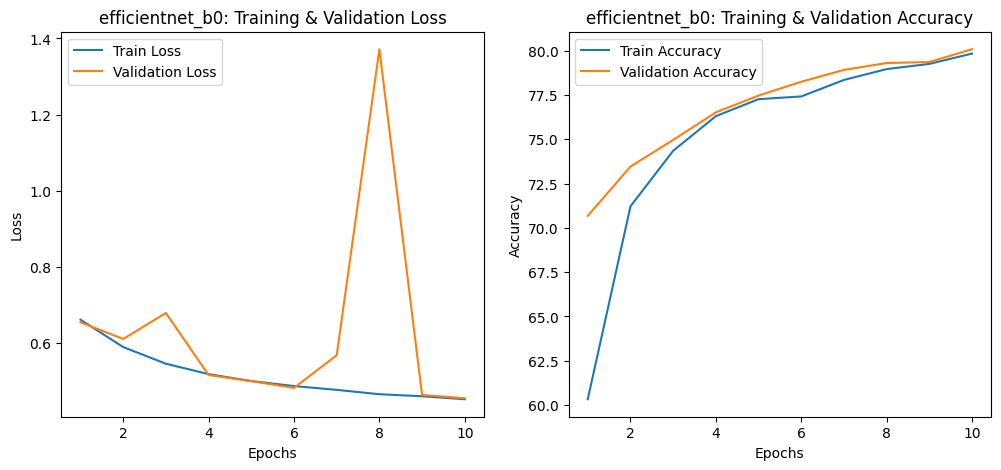

Training vgg16

Epoch 1/10


Train Loss: 0.4644, Train Accuracy: 77.96%


Val Loss: 0.3514, Val Accuracy: 84.64%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 2/10


Train Loss: 0.3084, Train Accuracy: 87.50%


Val Loss: 0.2979, Val Accuracy: 87.09%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 3/10


Train Loss: 0.2656, Train Accuracy: 89.33%


Val Loss: 0.2796, Val Accuracy: 87.53%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 4/10


Train Loss: 0.2392, Train Accuracy: 90.55%


Val Loss: 0.2713, Val Accuracy: 87.98%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 5/10


Train Loss: 0.2177, Train Accuracy: 91.43%


Val Loss: 0.2687, Val Accuracy: 88.15%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 6/10


Train Loss: 0.2000, Train Accuracy: 92.30%


Val Loss: 0.2674, Val Accuracy: 88.48%
✅ Best model saved: models\vgg16_fine_tune.pth

Epoch 7/10


Train Loss: 0.1787, Train Accuracy: 93.02%


Val Loss: 0.2707, Val Accuracy: 88.09%

Epoch 8/10


Train Loss: 0.1613, Train Accuracy: 93.94%


Val Loss: 0.2841, Val Accuracy: 88.31%

Epoch 9/10


Train Loss: 0.1429, Train Accuracy: 94.81%


Val Loss: 0.3007, Val Accuracy: 88.65%

Epoch 10/10


Train Loss: 0.1247, Train Accuracy: 95.52%


Val Loss: 0.3066, Val Accuracy: 88.48%


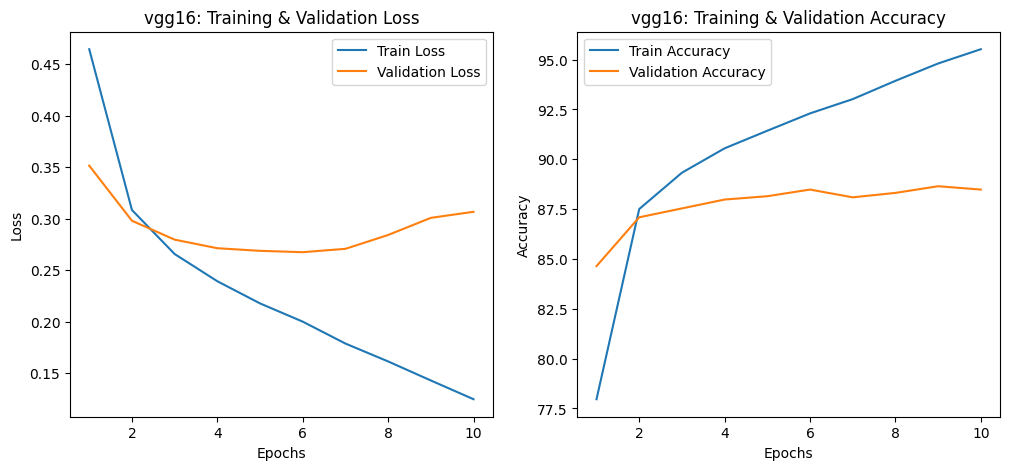

Training vgg19

Epoch 1/10


Train Loss: 0.4907, Train Accuracy: 75.40%


Val Loss: 0.3640, Val Accuracy: 84.14%
✅ Best model saved: models\vgg19_fine_tune.pth

Epoch 2/10


Train Loss: 0.3285, Train Accuracy: 86.15%


Val Loss: 0.3201, Val Accuracy: 85.81%
✅ Best model saved: models\vgg19_fine_tune.pth

Epoch 3/10


Train Loss: 0.2883, Train Accuracy: 88.20%


Val Loss: 0.3072, Val Accuracy: 85.59%
✅ Best model saved: models\vgg19_fine_tune.pth

Epoch 4/10


Train Loss: 0.2608, Train Accuracy: 89.33%


Val Loss: 0.2936, Val Accuracy: 87.15%
✅ Best model saved: models\vgg19_fine_tune.pth

Epoch 5/10


Train Loss: 0.2414, Train Accuracy: 90.28%


Val Loss: 0.2921, Val Accuracy: 86.59%
✅ Best model saved: models\vgg19_fine_tune.pth

Epoch 6/10


Train Loss: 0.2236, Train Accuracy: 91.16%


Val Loss: 0.2847, Val Accuracy: 87.09%
✅ Best model saved: models\vgg19_fine_tune.pth

Epoch 7/10


Train Loss: 0.2009, Train Accuracy: 92.27%


Val Loss: 0.2879, Val Accuracy: 87.48%

Epoch 8/10


Train Loss: 0.1819, Train Accuracy: 92.96%


Val Loss: 0.2854, Val Accuracy: 87.42%

Epoch 9/10


Train Loss: 0.1602, Train Accuracy: 93.76%


Val Loss: 0.3039, Val Accuracy: 87.48%

Epoch 10/10


Train Loss: 0.1401, Train Accuracy: 94.76%


Val Loss: 0.3122, Val Accuracy: 87.76%


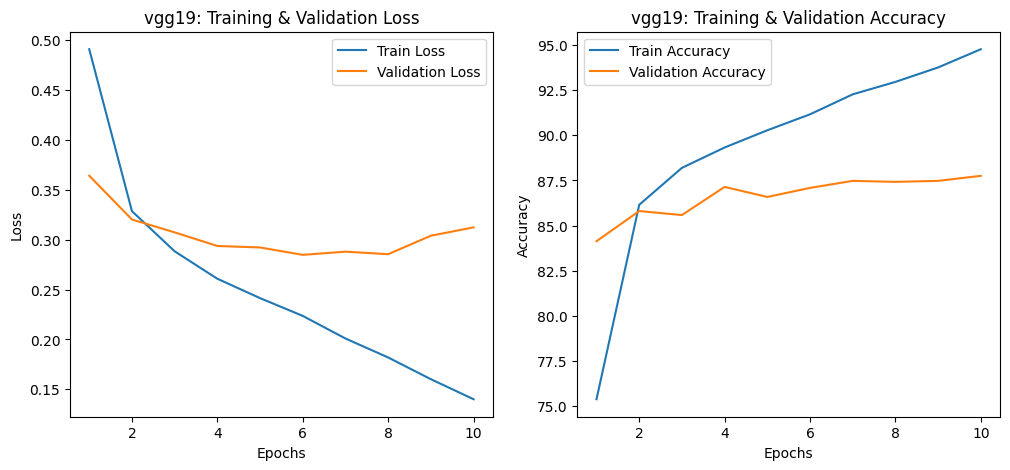

In [58]:
SAVE_DIR = "models"
NUM_EPOCHS = 10
LEARNING_RATE = 1e-5

model_dict = {}

for model_name in ["resnet50", "resnet18", "efficientnet_b0", "vgg16", "vgg19"]:

    print(f"Training {model_name}")
    
    model=get_model(model_name)

    # 🔹 Define Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 🔹 Initialize Trainer
    trainer = ModelTrainer(model, train_loader, val_loader, criterion, optimizer, model_name)

    model_path = os.path.join(SAVE_DIR,f"{model_name}_fine_tune.pth")

    # 🔹 Train Model
    trainer.train_model(NUM_EPOCHS, model_path)

    #cargando mejor estado del modelo
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)

    model_dict[model_name] = model

    # model.eval()
    # evaluate_model(model, test_loader)

    

Eval: vgg16


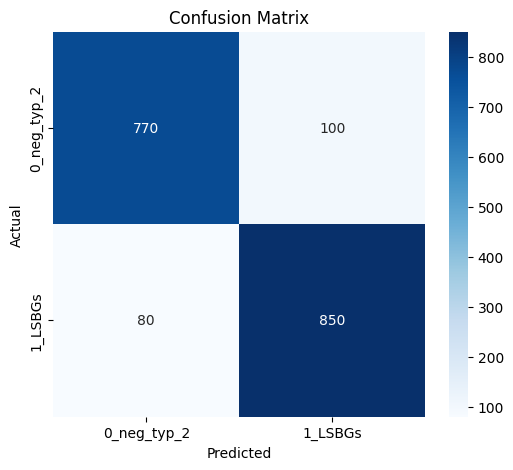

[[770 100]
 [ 80 850]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.91      0.89      0.90       870
     1_LSBGs       0.89      0.91      0.90       930

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800

Eval: resnet50


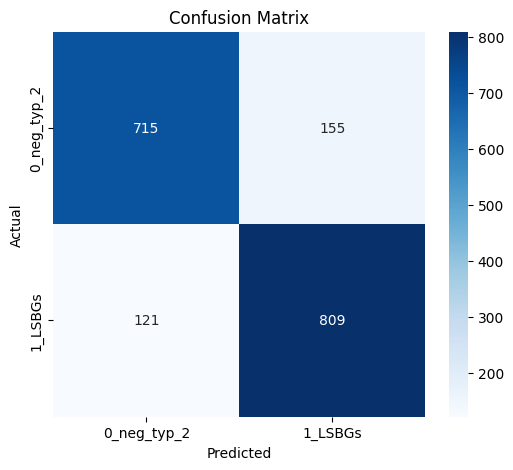

[[715 155]
 [121 809]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.86      0.82      0.84       870
     1_LSBGs       0.84      0.87      0.85       930

    accuracy                           0.85      1800
   macro avg       0.85      0.85      0.85      1800
weighted avg       0.85      0.85      0.85      1800

Eval: resnet18


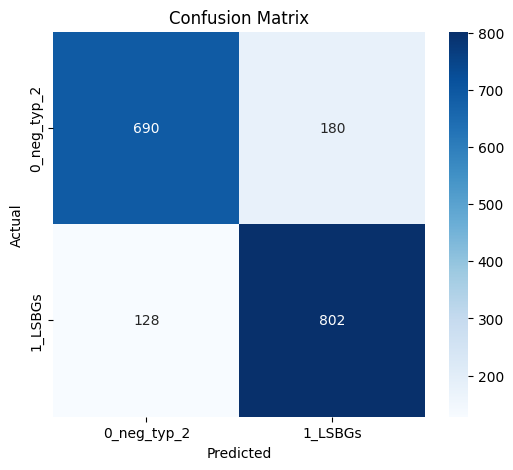

[[690 180]
 [128 802]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.84      0.79      0.82       870
     1_LSBGs       0.82      0.86      0.84       930

    accuracy                           0.83      1800
   macro avg       0.83      0.83      0.83      1800
weighted avg       0.83      0.83      0.83      1800

Eval: efficientnet_b0


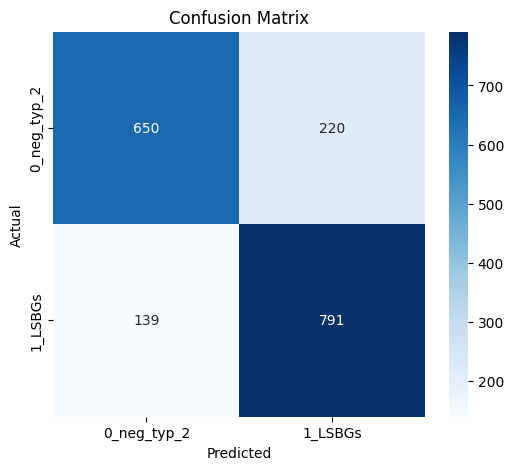

[[650 220]
 [139 791]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.82      0.75      0.78       870
     1_LSBGs       0.78      0.85      0.82       930

    accuracy                           0.80      1800
   macro avg       0.80      0.80      0.80      1800
weighted avg       0.80      0.80      0.80      1800

Eval: vgg19


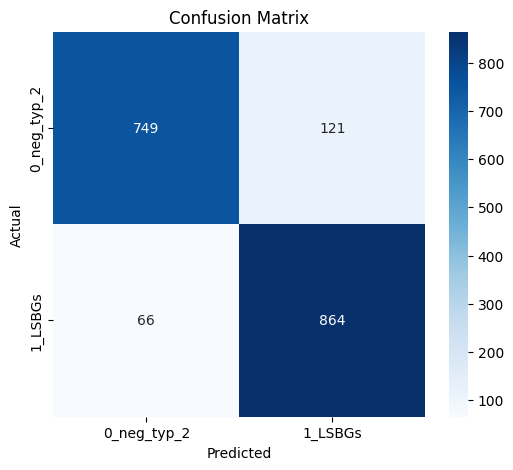

[[749 121]
 [ 66 864]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.92      0.86      0.89       870
     1_LSBGs       0.88      0.93      0.90       930

    accuracy                           0.90      1800
   macro avg       0.90      0.89      0.90      1800
weighted avg       0.90      0.90      0.90      1800



In [59]:
for model_name, model in model_dict.items():
    print(f"Eval: {model_name}")
    model.eval()
    evaluate_model(model, test_loader)

## Evaluate with Nair-Manga dataset

In [60]:
nair_manga_test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test_nair_manga"), transform = transform)

nair_manga_test_loader = DataLoader(nair_manga_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Class Mapping:", nair_manga_test_dataset.class_to_idx)

Class Mapping: {'0_neg_typ_2': 0, '1_LSBGs': 1}


Eval: vgg16


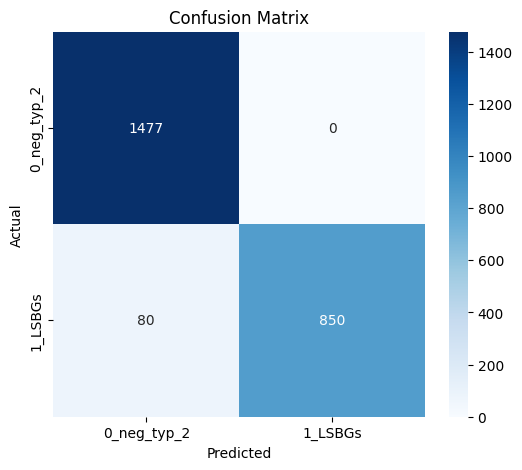

[[1477    0]
 [  80  850]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.95      1.00      0.97      1477
     1_LSBGs       1.00      0.91      0.96       930

    accuracy                           0.97      2407
   macro avg       0.97      0.96      0.96      2407
weighted avg       0.97      0.97      0.97      2407

Eval: resnet50


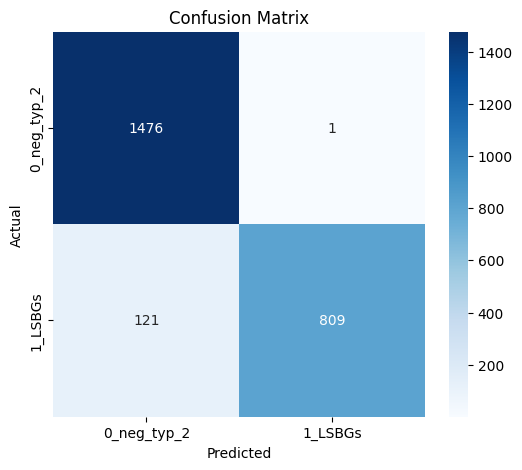

[[1476    1]
 [ 121  809]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.92      1.00      0.96      1477
     1_LSBGs       1.00      0.87      0.93       930

    accuracy                           0.95      2407
   macro avg       0.96      0.93      0.95      2407
weighted avg       0.95      0.95      0.95      2407

Eval: resnet18


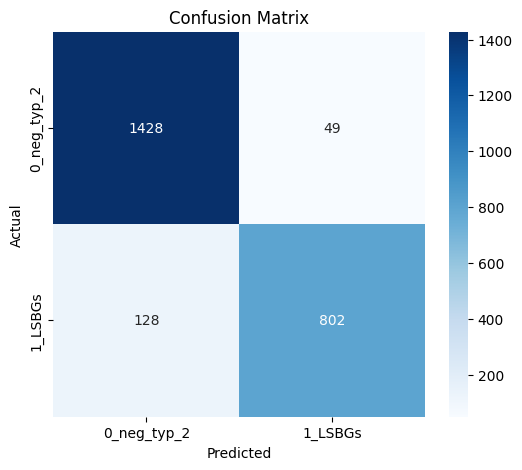

[[1428   49]
 [ 128  802]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.92      0.97      0.94      1477
     1_LSBGs       0.94      0.86      0.90       930

    accuracy                           0.93      2407
   macro avg       0.93      0.91      0.92      2407
weighted avg       0.93      0.93      0.93      2407

Eval: efficientnet_b0


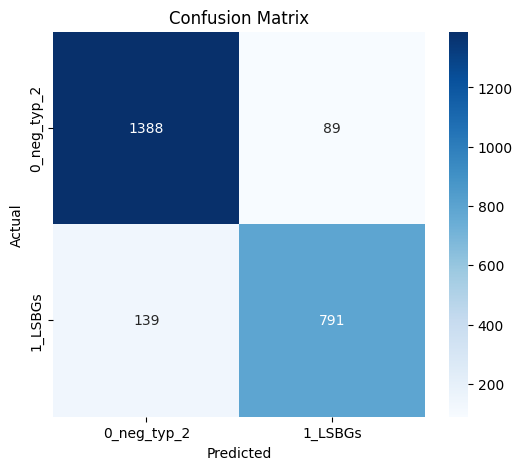

[[1388   89]
 [ 139  791]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.91      0.94      0.92      1477
     1_LSBGs       0.90      0.85      0.87       930

    accuracy                           0.91      2407
   macro avg       0.90      0.90      0.90      2407
weighted avg       0.91      0.91      0.90      2407

Eval: vgg19


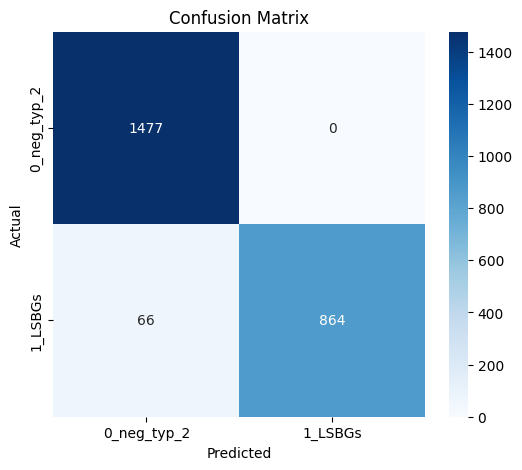

[[1477    0]
 [  66  864]]

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.96      1.00      0.98      1477
     1_LSBGs       1.00      0.93      0.96       930

    accuracy                           0.97      2407
   macro avg       0.98      0.96      0.97      2407
weighted avg       0.97      0.97      0.97      2407



In [61]:
for model_name, model in model_dict.items():
    print(f"Eval: {model_name}")
    model.eval()
    evaluate_model(model, nair_manga_test_loader)

In [ ]:
# for model_name in ["vgg16", "resnet50", "resnet18", "efficientnet_b0", "vgg16", "vgg19"]:

#     print(f"Training {model_name}")
    
#     model=get_model(model_name)

#     # 🔹 Define Loss Function and Optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#     # 🔹 Initialize Trainer
#     trainer = ModelTrainer(model, train_loader, val_loader, criterion, optimizer, model_name)

#     model_path = os.path.join(SAVE_DIR,f"{model_name}_fine_tune.pth")

#     # 🔹 Train Model
#     trainer.train_model(NUM_EPOCHS, model_path)

#     model.load_state_dict(torch.load(model_path))
#     model = model.to(device)
#     model.eval()
#     evaluate_model(model, test_loader)

# vgg16


Epoch 1/10


Train Loss: 0.4403, Train Accuracy: 79.71%


Val Loss: 0.3190, Val Accuracy: 86.48%
✅ Best model saved: models\vgg16_best.pth

Epoch 2/10


Train Loss: 0.2950, Train Accuracy: 87.96%


Val Loss: 0.2933, Val Accuracy: 87.20%
✅ Best model saved: models\vgg16_best.pth

Epoch 3/10


Train Loss: 0.2591, Train Accuracy: 89.71%


Val Loss: 0.2789, Val Accuracy: 87.98%
✅ Best model saved: models\vgg16_best.pth

Epoch 4/10


Train Loss: 0.2354, Train Accuracy: 90.65%


Val Loss: 0.2661, Val Accuracy: 88.59%
✅ Best model saved: models\vgg16_best.pth

Epoch 5/10


Train Loss: 0.2131, Train Accuracy: 91.71%


Val Loss: 0.2632, Val Accuracy: 88.54%
✅ Best model saved: models\vgg16_best.pth

Epoch 6/10


Train Loss: 0.1952, Train Accuracy: 92.65%


Val Loss: 0.2582, Val Accuracy: 89.09%
✅ Best model saved: models\vgg16_best.pth

Epoch 7/10


Train Loss: 0.1788, Train Accuracy: 93.37%


Val Loss: 0.2639, Val Accuracy: 88.81%

Epoch 8/10


Train Loss: 0.1604, Train Accuracy: 94.32%


Val Loss: 0.2721, Val Accuracy: 88.70%

Epoch 9/10


Train Loss: 0.1400, Train Accuracy: 95.16%


Val Loss: 0.2867, Val Accuracy: 88.70%

Epoch 10/10


Train Loss: 0.1218, Train Accuracy: 95.74%


Val Loss: 0.2968, Val Accuracy: 88.70%


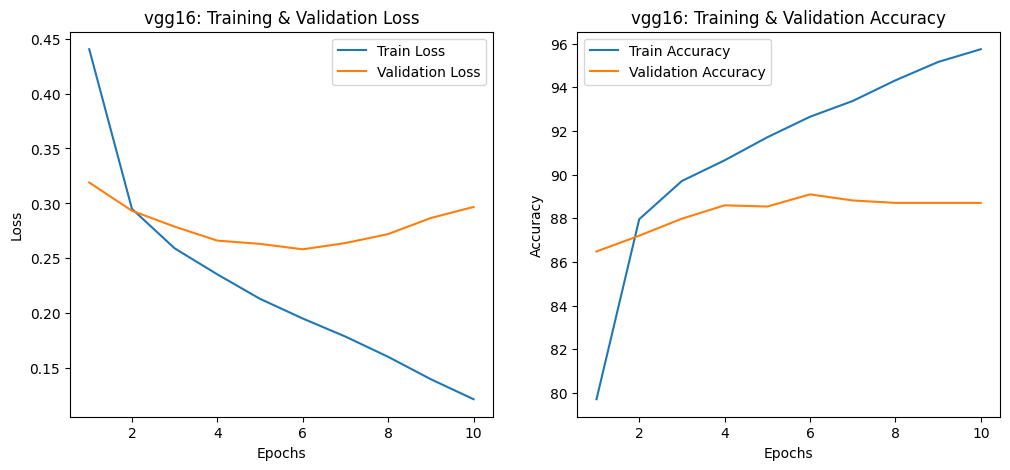

In [41]:
# 🔹 Define Training Parameters
#MODEL_NAME = "vgg16"  # Change to "resnet50", "resnet18", "efficientnet_b0", "vgg16", or "vgg19"
NUM_EPOCHS = 10
LEARNING_RATE = 1e-5

#NUM_CLASSES = 2  # Binary classification (LSBG vs. non-LSBG)

# 🔹 Load Selected Model
vgg16_model = get_model("vgg16")

# 🔹 Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_model.parameters(), lr=LEARNING_RATE)

# 🔹 Initialize Trainer
trainer = ModelTrainer(vgg16_model, train_loader, val_loader, criterion, optimizer, "vgg16")

# 🔹 Train Model
trainer.train_model(NUM_EPOCHS, SAVE_DIR)

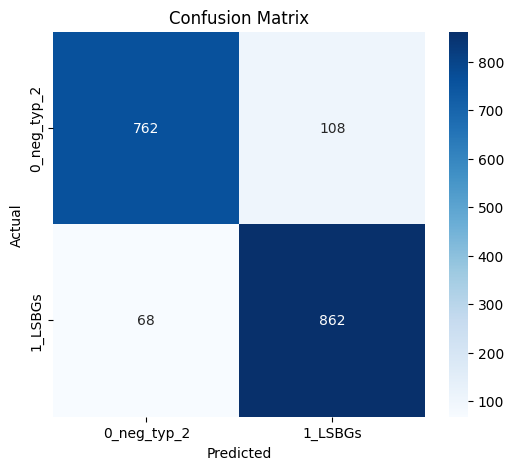

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.92      0.88      0.90       870
     1_LSBGs       0.89      0.93      0.91       930

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



In [42]:
vgg16_model.load_state_dict(torch.load(os.path.join(SAVE_DIR, f"vgg16_best.pth")))
vgg16_model = vgg16_model.to(device)
vgg16_model.eval()
evaluate_model(vgg16_model, test_loader)

# resnet50


Epoch 1/10


Train Loss: 0.6436, Train Accuracy: 65.16%


Val Loss: 0.5864, Val Accuracy: 72.06%
✅ Best model saved: models\resnet50_best.pth

Epoch 2/10


Train Loss: 0.5401, Train Accuracy: 76.12%


Val Loss: 0.5058, Val Accuracy: 76.07%
✅ Best model saved: models\resnet50_best.pth

Epoch 3/10


Train Loss: 0.4655, Train Accuracy: 79.44%


Val Loss: 0.4676, Val Accuracy: 78.30%
✅ Best model saved: models\resnet50_best.pth

Epoch 4/10


Train Loss: 0.4241, Train Accuracy: 81.48%


Val Loss: 0.4493, Val Accuracy: 79.74%
✅ Best model saved: models\resnet50_best.pth

Epoch 5/10


Train Loss: 0.3948, Train Accuracy: 82.89%


Val Loss: 0.4356, Val Accuracy: 80.58%
✅ Best model saved: models\resnet50_best.pth

Epoch 6/10


Train Loss: 0.3732, Train Accuracy: 83.93%


Val Loss: 0.4286, Val Accuracy: 81.52%
✅ Best model saved: models\resnet50_best.pth

Epoch 7/10


Train Loss: 0.3576, Train Accuracy: 84.26%


Val Loss: 0.4238, Val Accuracy: 81.86%
✅ Best model saved: models\resnet50_best.pth

Epoch 8/10


Train Loss: 0.3427, Train Accuracy: 85.10%


Val Loss: 0.4132, Val Accuracy: 82.75%
✅ Best model saved: models\resnet50_best.pth

Epoch 9/10


Train Loss: 0.3292, Train Accuracy: 85.72%


Val Loss: 0.4142, Val Accuracy: 82.36%

Epoch 10/10


Train Loss: 0.3160, Train Accuracy: 86.08%


Val Loss: 0.4068, Val Accuracy: 83.19%
✅ Best model saved: models\resnet50_best.pth


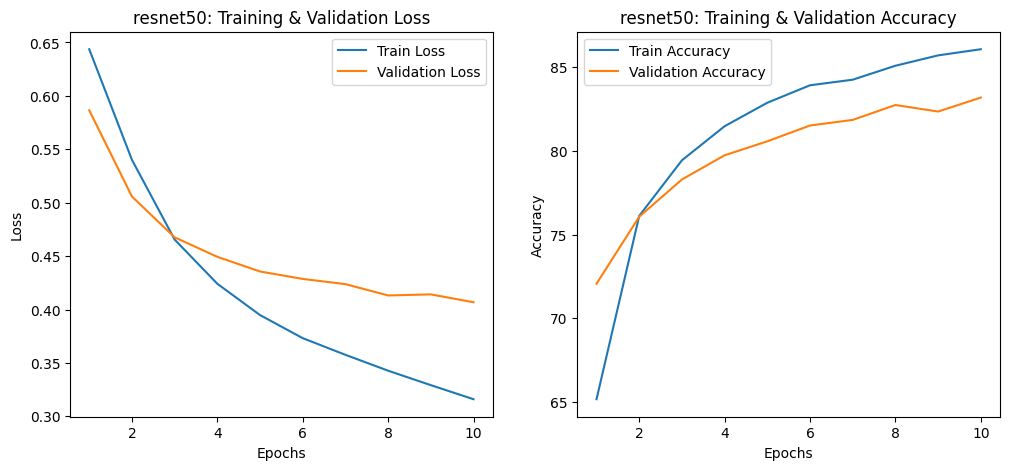

In [43]:
# 🔹 Define Training Parameters
NUM_EPOCHS = 10
LEARNING_RATE = 1e-5

# 🔹 Load Selected Model
model_resnet50 = get_model("resnet50")

# 🔹 Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet50.parameters(), lr=LEARNING_RATE)

# 🔹 Initialize Trainer
trainer = ModelTrainer(model_resnet50, train_loader, val_loader, criterion, optimizer, "resnet50")

# 🔹 Train Model
trainer.train_model(NUM_EPOCHS, SAVE_DIR)

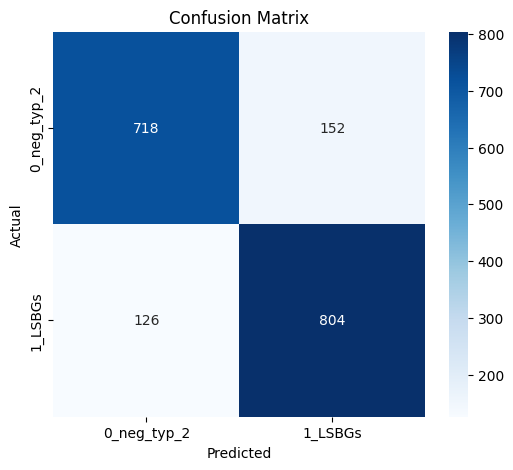

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.85      0.83      0.84       870
     1_LSBGs       0.84      0.86      0.85       930

    accuracy                           0.85      1800
   macro avg       0.85      0.84      0.85      1800
weighted avg       0.85      0.85      0.85      1800



In [44]:
model_resnet50.load_state_dict(torch.load(os.path.join(SAVE_DIR, f"resnet50_best.pth")))
model_resnet50 = model_resnet50.to(device)
model_resnet50.eval()
evaluate_model(model_resnet50, test_loader)

# efficientnet_b0


Epoch 1/10


Train Loss: 0.6702, Train Accuracy: 58.33%


Val Loss: 0.8922, Val Accuracy: 70.28%
✅ Best model saved: models\efficientnet_b0_best.pth

Epoch 2/10


Train Loss: 0.5925, Train Accuracy: 70.74%


Val Loss: 0.6923, Val Accuracy: 74.51%
✅ Best model saved: models\efficientnet_b0_best.pth

Epoch 3/10


Train Loss: 0.5482, Train Accuracy: 73.80%


Val Loss: 0.5251, Val Accuracy: 76.46%
✅ Best model saved: models\efficientnet_b0_best.pth

Epoch 4/10


Train Loss: 0.5182, Train Accuracy: 75.96%


Val Loss: 0.5029, Val Accuracy: 76.91%
✅ Best model saved: models\efficientnet_b0_best.pth

Epoch 5/10


Train Loss: 0.5009, Train Accuracy: 77.07%


Val Loss: 0.4897, Val Accuracy: 77.69%
✅ Best model saved: models\efficientnet_b0_best.pth

Epoch 6/10


Train Loss: 0.4857, Train Accuracy: 77.84%


Val Loss: 0.5062, Val Accuracy: 78.41%

Epoch 7/10


Train Loss: 0.4757, Train Accuracy: 78.20%


Val Loss: 0.4828, Val Accuracy: 78.85%
✅ Best model saved: models\efficientnet_b0_best.pth

Epoch 8/10


Train Loss: 0.4689, Train Accuracy: 78.66%


Val Loss: 0.4625, Val Accuracy: 79.47%
✅ Best model saved: models\efficientnet_b0_best.pth

Epoch 9/10


Train Loss: 0.4612, Train Accuracy: 78.89%


Val Loss: 0.4553, Val Accuracy: 79.24%
✅ Best model saved: models\efficientnet_b0_best.pth

Epoch 10/10


Train Loss: 0.4554, Train Accuracy: 79.51%


Val Loss: 0.6362, Val Accuracy: 79.74%


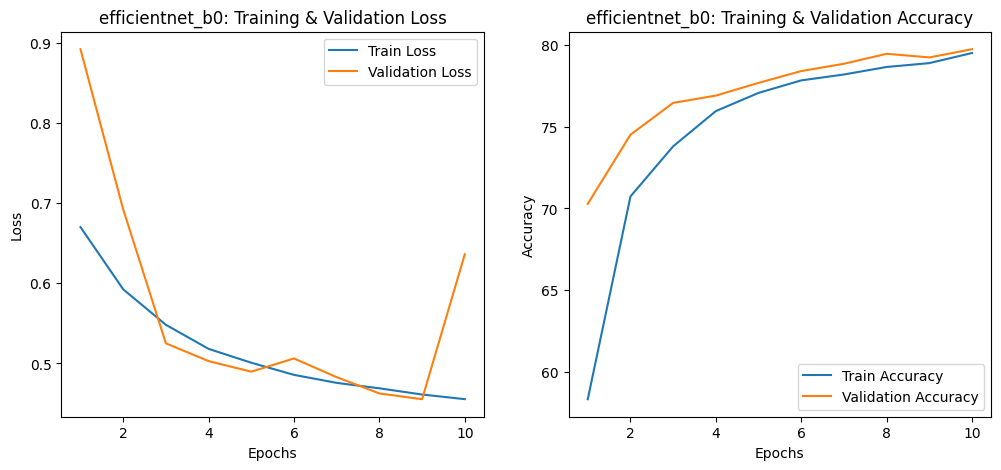

In [45]:
# 🔹 Define Training Parameters
NUM_EPOCHS = 10
LEARNING_RATE = 1e-5

# 🔹 Load Selected Model
model_efficientnet_b0 = get_model("efficientnet_b0")

# 🔹 Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet_b0.parameters(), lr=LEARNING_RATE)

# 🔹 Initialize Trainer
trainer = ModelTrainer(model_efficientnet_b0, train_loader, val_loader, criterion, optimizer, "efficientnet_b0")

# 🔹 Train Model
trainer.train_model(NUM_EPOCHS, SAVE_DIR)

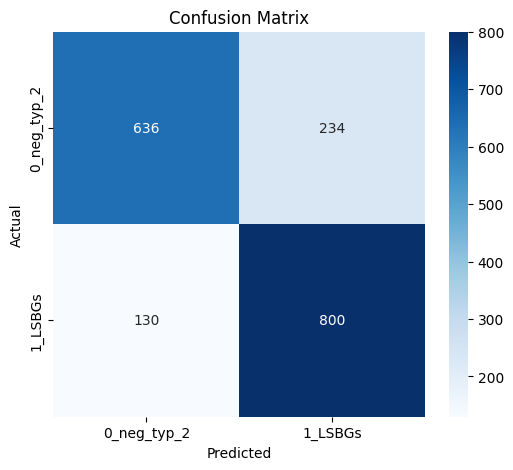

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.83      0.73      0.78       870
     1_LSBGs       0.77      0.86      0.81       930

    accuracy                           0.80      1800
   macro avg       0.80      0.80      0.80      1800
weighted avg       0.80      0.80      0.80      1800



In [46]:
model_efficientnet_b0.load_state_dict(torch.load(os.path.join(SAVE_DIR, f"efficientnet_b0_best.pth")))
model_efficientnet_b0 = model_efficientnet_b0.to(device)
model_efficientnet_b0.eval()
evaluate_model(model_efficientnet_b0, test_loader)

# Evaluación de Modelos para la Clasificación de LSBGs

## **1. Introducción**
El objetivo de este experimento fue evaluar distintos modelos de redes neuronales preentrenadas aplicadas a la clasificación de **Low Surface Brightness Galaxies (LSBGs)**. Se utilizaron cinco arquitecturas diferentes: **ResNet50, ResNet18, EfficientNet-B0, VGG16 y VGG19**, las cuales fueron **finamente ajustadas (fine-tuned)** para adaptarse al problema. 

El desempeño de los modelos se midió utilizando una matriz de confusión y métricas de clasificación como **precisión (precision), recall, f1-score y exactitud (accuracy)**.

---

## **2. Resultados de Evaluación**
Los resultados en el conjunto de prueba se presentan a continuación:

| **Modelo**          | **Accuracy** | **Precision (LSBGs)** | **Recall (LSBGs)** | **F1-score (LSBGs)** |
|---------------------|-------------|----------------------|------------------|------------------|
| **ResNet50**       | **95%**      | 1.00                 | 0.87             | 0.93             |
| **ResNet18**       | 93%          | 0.94                 | 0.86             | 0.90             |
| **EfficientNet-B0**| 91%          | 0.90                 | 0.85             | 0.87             |
| **VGG16**          | **97%**      | **1.00**             | 0.91             | **0.96**         |
| **VGG19**          | **97%**      | **1.00**             | **0.93**         | **0.96**         |

---

## **3. Análisis Comparativo**
### **Precisión y Exactitud**
- **VGG16 y VGG19** fueron los modelos con **mayor exactitud (97%)** y lograron **una precisión perfecta (1.00) en la detección de LSBGs**.  
- **ResNet50** obtuvo una precisión similar (1.00) pero una exactitud ligeramente inferior (95%).  
- **EfficientNet-B0** tuvo el desempeño más bajo, con un 91% de exactitud y un recall menor en la detección de LSBGs.

### **Capacidad de Detección de LSBGs (Recall)**
- **VGG19 obtuvo el mejor recall (0.93)**, lo que significa que identificó correctamente un mayor número de LSBGs en comparación con los otros modelos.  
- **ResNet50 y VGG16 tuvieron valores de recall ligeramente menores (0.87 y 0.91, respectivamente).**  
- **EfficientNet-B0 y ResNet18 fueron los peores en recall**, con valores de 0.85 y 0.86, respectivamente, lo que indica que omitieron más LSBGs.

### **Balance General (F1-score)**
- **VGG16 y VGG19 son los modelos con el mejor equilibrio entre precisión y recall, obteniendo un F1-score de 0.96**.
- **ResNet50 también mostró un buen rendimiento con un F1-score de 0.93**.
- **EfficientNet-B0 tuvo el peor desempeño con un F1-score de 0.87**, lo que sugiere que no es la mejor opción para este problema.

---

## **4. Conclusión: ¿Cuál es el Mejor Modelo?**
Basándonos en los resultados de clasificación en el conjunto de prueba, el mejor modelo para la tarea de detección de **Low Surface Brightness Galaxies (LSBGs)** es **VGG19**.

### **Razones por las que VGG19 es el mejor modelo:**
1. **Mayor precisión (1.00)** en la detección de LSBGs.  
2. **Mejor recall (0.93)**, asegurando la detección de más LSBGs.  
3. **F1-score más alto (0.96)**, lo que indica un buen equilibrio entre precisión y recall.  
4. **Mayor exactitud global (97%)**, lo que lo hace confiable para clasificar ambos tipos de galaxias.  